In [149]:
import os
import pandas as pd

collect_mi_csv = "/home/igor/igor_repos/noise_scaling_laws/Scaling-up-measurement-noise-scaling-laws/collect_mi_results.csv"
old_mi = pd.read_csv(collect_mi_csv)

if 'umis_per_cell' in old_mi.columns:
    old_mi = old_mi.drop(columns=['umis_per_cell'])

experiment_configs = {
    "larry": (100000, 0.0847557, ["clone"]),
    "PBMC": (100000, 0.1072766, ["protein_counts"]),
    "shendure": (10000000, 0.0859506, ["author_day"]),
    "merfish": (60000, 0.0905502, ["ng_idx"]),
}

criteria = []
for dataset, (size, quality, signals) in experiment_configs.items():
    for signal in signals:
        if dataset == "merfish":
            seed = 1404
        else:
            seed = 42
        mask = (
            (old_mi['dataset'].str.lower() == dataset.lower())
            & (old_mi['size'] == size)
            & (old_mi['quality'] == quality)
            & (old_mi['signal'] == signal)
            & (old_mi['seed'] == seed)
        )
        criteria.append(mask)
from functools import reduce
import operator
if criteria:
    combined_mask = reduce(operator.or_, criteria)
    mi_csv_df = old_mi[combined_mask].reset_index(drop=True)
    if 'umis_per_cell' in mi_csv_df.columns:
        mi_csv_df = mi_csv_df.drop(columns=['umis_per_cell'])
    if "mi" in mi_csv_df.columns:
        mi_csv_df = mi_csv_df.rename(columns={"mi": "collected_mi"})
    if "mi_value" in mi_csv_df.columns:
        mi_csv_df = mi_csv_df.rename(columns={"mi_value": "collected_mi"})
else:
    mi_csv_df = pd.DataFrame()

base_dir = "/home/igor/igor_repos/noise_scaling_laws/Scaling-up-measurement-noise-scaling-laws/analysis/outputs/2025-12-02_19-54_evaluate_mid_quality_models_on_full_data"
algorithms = ["Geneformer", "PCA", "SCVI", "RandomProjection"]

records = []

for dataset, (size, bvalue, signals) in experiment_configs.items():
    for algo in algorithms:
        for signal in signals:
            seed = 42
            if algo == "Geneformer":
                path_new = f"{base_dir}/{dataset}/{size}/{bvalue}/results/{algo}/model/MI/{seed}/Y_{signal}_{bvalue}_{algo.lower()}"
            else:
                path_new = f"{base_dir}/{dataset}/{size}/{bvalue}/results/{algo}/model/MI/{seed}/Y_{signal}_{bvalue}"
            file_original_compare_to_mi = os.path.join(path_new, "lmi_mutual_information.txt")

            if algo == "Geneformer":
                path_old = f"{base_dir}/{dataset}/{size}/{bvalue}/results/{algo}/model/MI/{seed}/Y_{signal}_1.0_{algo.lower()}"
            else:
                path_old = f"{base_dir}/{dataset}/{size}/{bvalue}/results/{algo}/model/MI/{seed}/Y_{signal}_1.0"
            file_new_experiment_results = os.path.join(path_old, "lmi_mutual_information.txt")

            if os.path.exists(file_original_compare_to_mi):
                try:
                    with open(file_original_compare_to_mi, "r") as f:
                        lmi_original_compare_to_mi = f.read().strip()
                except Exception:
                    lmi_original_compare_to_mi = None
            else:
                lmi_original_compare_to_mi = None

            if os.path.exists(file_new_experiment_results):
                try:
                    with open(file_new_experiment_results, "r") as f:
                        lmi_new_experiment_results = f.read().strip()
                except Exception:
                    lmi_new_experiment_results = None
            else:
                lmi_new_experiment_results = None

            records.append({
                "dataset": dataset,
                "size": size,
                "bvalue": bvalue,
                "signal": signal,
                "algorithm": algo,
                "seed": seed,
                "lmi_new_experiment_results": lmi_new_experiment_results,
                "lmi_original_compare_to_mi": lmi_original_compare_to_mi
            })

mi_fs_df = pd.DataFrame(records)

if 'seed' in mi_fs_df.columns:
    mi_fs_df = mi_fs_df.drop(columns=['seed'])
if 'seed' in mi_csv_df.columns:
    mi_csv_df = mi_csv_df.drop(columns=['seed'])
if 'umis_per_cell' in mi_fs_df.columns:
    mi_fs_df = mi_fs_df.drop(columns=['umis_per_cell'])
if 'umis_per_cell' in mi_csv_df.columns:
    mi_csv_df = mi_csv_df.drop(columns=['umis_per_cell'])

mi_csv_df = mi_csv_df.rename(columns={'quality': 'bvalue'})

mi_fs_df['signal'] = mi_fs_df['signal'].astype(str)
mi_csv_df['signal'] = mi_csv_df['signal'].astype(str)
mi_fs_df['algorithm'] = mi_fs_df['algorithm'].astype(str)
mi_csv_df['algorithm'] = mi_csv_df['algorithm'].astype(str)

merged_df = pd.merge(
    mi_fs_df,
    mi_csv_df,
    how='left',
    on=['dataset', 'size', 'bvalue', 'signal', 'algorithm'],
    suffixes=('', '_csv')
)

merged_df

,dataset,size,bvalue,signal,algorithm,lmi_new_experiment_results,lmi_original_compare_to_mi,collected_mi
0,larry,100000,0.084756,clone,Geneformer,0.79156,0.83491,0.70107
1,larry,100000,0.084756,clone,PCA,1.26839,0.50498,0.47688
2,larry,100000,0.084756,clone,SCVI,1.52152,1.06555,1.06068
3,larry,100000,0.084756,clone,RandomProjection,0.39873,0.08584,0.06428
4,PBMC,100000,0.107277,protein_counts,Geneformer,None,3.45581,3.33206
5,PBMC,100000,0.107277,protein_counts,PCA,3.40407,2.58175,2.65009
6,PBMC,100000,0.107277,protein_counts,SCVI,4.32807,3.97831,3.91218
7,PBMC,100000,0.107277,protein_counts,RandomProjection,2.86534,1.87921,1.85624
8,shendure,10000000,0.085951,author_day,Geneformer,1.77112,1.73928,1.41682
9,shendure,10000000,0.085951,author_day,PCA,None,None,0.41013


In [150]:
# For comparison, select only seed=42 rows from the CSV that match our experiment_configs (quality=1.0/full data quality),
# EXCEPT for merfish, where we use seed=1404
collect_mi_df = pd.read_csv(collect_mi_csv)
experiment_configs = {
    "larry": (100000, 0.0847557, ["clone"]),
    "PBMC": (100000, 0.1072766, ["protein_counts"]),
    "shendure": (10000000, 0.0859506, ["author_day"]),
    "merfish": (60000, 0.0905502, ["ng_idx"]),
}

dfs = []
for dataset, (size, bvalue, signals) in experiment_configs.items():
    for signal in signals:
        if dataset.lower() == 'merfish':
            desired_seed = 1404
        else:
            desired_seed = 42
        subset = collect_mi_df[
            (collect_mi_df['dataset'].str.lower() == dataset.lower()) &
            (collect_mi_df['size'] == size) &
            (collect_mi_df['quality'] == 1.0) &
            (collect_mi_df['signal'] == signal) &
            (collect_mi_df['seed'] == desired_seed)
        ].copy()
        if not subset.empty:
            # Remove the 'seed' column if it exists.
            if 'seed' in subset.columns:
                subset = subset.drop(columns=['seed'])
            dfs.append(subset)
collect_mi_selected = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()
collect_mi_selected

,dataset,size,quality,algorithm,signal,mi_value,umis_per_cell
0,larry,100000,1.0,Geneformer,clone,0.87810,2580
1,larry,100000,1.0,PCA,clone,1.41693,2580
2,larry,100000,1.0,RandomProjection,clone,0.34995,2580
3,larry,100000,1.0,SCVI,clone,1.72356,2580
4,PBMC,100000,1.0,Geneformer,protein_counts,3.66579,8100
5,PBMC,100000,1.0,PCA,protein_counts,3.92997,8100
6,PBMC,100000,1.0,RandomProjection,protein_counts,2.83812,8100
7,PBMC,100000,1.0,SCVI,protein_counts,4.72651,8100
8,shendure,10000000,1.0,Geneformer,author_day,1.95532,2500
9,shendure,10000000,1.0,PCA,author_day,1.14821,2500


In [151]:
# Merge collect_mi_selected into merged_df to add "upperopound_mi" column
# The matching should be on: dataset, size, algorithm, signal.
# Note that "bvalue" or "quality" do not match exactly, but those fields vary between these DataFrames and are not needed for this merge.

# Prepare the right columns for the merge from collect_mi_selected (mi_value = upperopound_mi)
upper_bound_df = collect_mi_selected[["dataset", "size", "algorithm", "signal", "mi_value"]].copy()
upper_bound_df = upper_bound_df.rename(columns={"mi_value": "upperopound_mi"})

# Merge: keep all rows from merged_df, add upperopound_mi from upper_bound_df where keys match
merged_df = pd.merge(
    merged_df,
    upper_bound_df,
    how="left",
    on=["dataset", "size", "algorithm", "signal"]
)
merged_df

,dataset,size,bvalue,signal,algorithm,lmi_new_experiment_results,lmi_original_compare_to_mi,collected_mi,upperopound_mi
0,larry,100000,0.084756,clone,Geneformer,0.79156,0.83491,0.70107,0.87810
1,larry,100000,0.084756,clone,PCA,1.26839,0.50498,0.47688,1.41693
2,larry,100000,0.084756,clone,SCVI,1.52152,1.06555,1.06068,1.72356
3,larry,100000,0.084756,clone,RandomProjection,0.39873,0.08584,0.06428,0.34995
4,PBMC,100000,0.107277,protein_counts,Geneformer,None,3.45581,3.33206,3.66579
5,PBMC,100000,0.107277,protein_counts,PCA,3.40407,2.58175,2.65009,3.92997
6,PBMC,100000,0.107277,protein_counts,SCVI,4.32807,3.97831,3.91218,4.72651
7,PBMC,100000,0.107277,protein_counts,RandomProjection,2.86534,1.87921,1.85624,2.83812
8,shendure,10000000,0.085951,author_day,Geneformer,1.77112,1.73928,1.41682,1.95532
9,shendure,10000000,0.085951,author_day,PCA,None,None,0.41013,1.14821


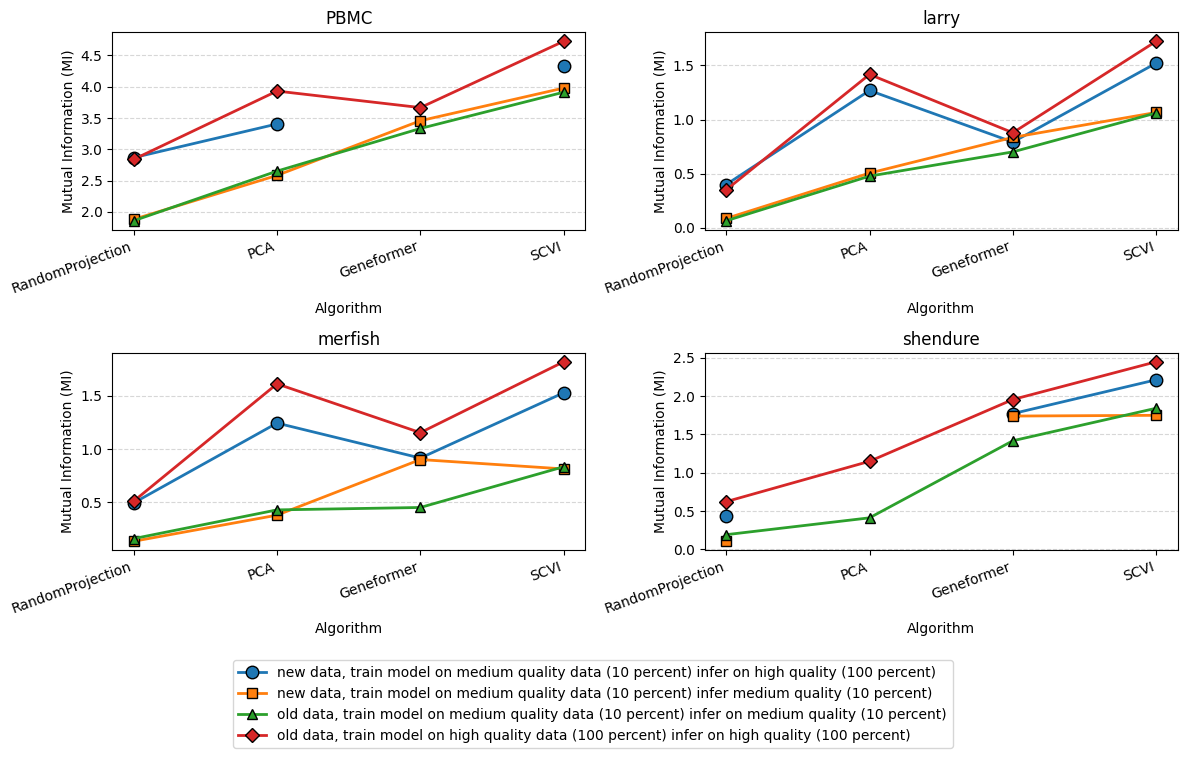

In [152]:
import matplotlib.pyplot as plt

# Use exact column names from merged_df as constructed above:
# 'lmi_new_experiment_results', 'lmi_original_compare_to_mi', 'collected_mi', 'upperopound_mi'

df = merged_df.copy()
dataset_names = ['PBMC', 'larry', 'merfish', 'shendure']
titles = {
    'PBMC': 'PBMC',
    'larry': 'larry',
    'merfish': 'merfish',
    'shendure': 'shendure'
}

fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharey=False)

algo_order = ['RandomProjection', 'PCA', 'Geneformer', 'SCVI']

# Add 'upperopound_mi' to the plotted columns.
mi_columns = [
    ('lmi_new_experiment_results', 'new data, train model on medium quality data (10 percent) infer on high quality (100 percent)', 'C0', 'o'),
    ('lmi_original_compare_to_mi', 'new data, train model on medium quality data (10 percent) infer medium quality (10 percent)', 'C1', 's'),
    ('collected_mi', 'old data, train model on medium quality data (10 percent) infer on medium quality (10 percent)', 'C2', '^'),
    ('upperopound_mi', 'old data, train model on high quality data (100 percent) infer on high quality (100 percent)', 'C3', 'D')
]

# Collect handles and labels only from the first plot drawn (avoid duplicates)
legend_handles = []
legend_labels = []

for idx, dataset in enumerate(dataset_names):
    ax = axs[idx // 2, idx % 2]
    subset = df[df['dataset'].str.lower() == dataset.lower()]
    # Set index to algorithm and reindex for consistent order
    if not subset.empty:
        subset = subset.set_index('algorithm').reindex(algo_order).reset_index()
        x_pos = range(len(algo_order))

        handles_this_ax = []
        for i, (colname, label, color, marker) in enumerate(mi_columns):
            if colname in subset:
                vals = pd.to_numeric(subset[colname], errors='coerce')
            else:
                vals = None
            # line plot (connect the points)
            line, = ax.plot(
                x_pos, 
                vals, 
                label=label, 
                color=color, 
                marker=marker,
                markersize=9 if marker == 'o' else 7,
                linewidth=2,
                markeredgecolor='k',
                zorder=2
            )
            # Only collect handles/labels for the legend from the first subplot
            if idx == 0:
                legend_handles.append(line)
                legend_labels.append(label)
    else:
        # No data for this dataset; plot empty points/lines
        x_pos = range(len(algo_order))
        for i, (_, label, color, marker) in enumerate(mi_columns):
            line, = ax.plot(x_pos, [None]*len(algo_order), label=label, color=color, marker=marker, linewidth=2, markersize=7, markeredgecolor='k', zorder=2)
            if idx == 0:
                legend_handles.append(line)
                legend_labels.append(label)

    ax.set_title(titles[dataset])
    ax.set_xlabel('Algorithm')
    ax.set_ylabel('Mutual Information (MI)')
    ax.set_xticks(list(range(len(algo_order))))
    ax.set_xticklabels(algo_order, rotation=20, ha='right')
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    # REMOVE per-axes legend here!

# Only one legend below the figure:
fig.legend(
    handles=legend_handles, 
    labels=legend_labels, 
    loc='lower center', 
    bbox_to_anchor=(0.5, 0.05),  # lower down to fit 4 rows
    ncol=1, 
    fontsize=10,
    frameon=True
)

plt.tight_layout(rect=[0, 0.18, 1, 1])  # leave space for tall legend below
plt.show()
